# TP 6 Réseaux de neurones - Multi classification et Propagation en arrière
Dans ce TP, nous aimerions entrainer un réseau de neurones pour la tâche de classification en utilisant l'algorithme d propagation en arrière (backpropagation).

L'ensemble de données que nous allons utiliser est le même que celui utilisé durant le TP1, i.e. les images de chiffres manuscrits.


# Importation des librairies necessaires au travail

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import random
import cv2 

# Lecture des fichiers de données
Pour ce TP, nous allons lire les données à partir d'un fichier csv.

In [2]:
from google.colab import drive as drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [3]:
# données
data = np.genfromtxt("/content/gdrive/My Drive/TP/TP6/data.csv", delimiter=',', dtype=float)
data.shape

(5000, 401)

Dans ces données (data), les 400 premières colonnes representent les pixels de l'image (20x20), la dernière colonne represente la classe de l'image (chiffres de 0 à 9). (http://yann.lecun.com/exdb/mnist/)

Chaque ligne represente un exemple de notre ensemble de données. 

Mettons ces données dans leus vecteurs correspondants.

In [9]:
# rajoutons l'ordonnée à l'origine theta 0
intercept=np.ones((data.shape[0],1))
X=np.column_stack((intercept,data[:,:-1]))
y=data[:,-1]
# forcer y à avoir une seule colonne
y = y.reshape( y.shape[0], 1)

In [10]:
print('X', X.shape ,' y ', y.shape)

X (5000, 401)  y  (5000, 1)


Visualisation aléatoire de quelques données

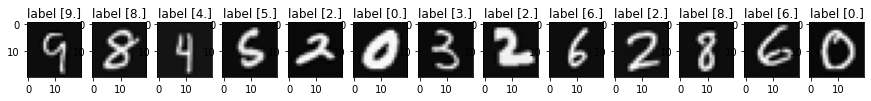

In [11]:
plt.figure(figsize=(15,8))
for i in range(13):
    c = random.randint(X.shape[0])
    a = X[c,1:].reshape((20, 20))
    a=np.transpose(a)
    plt.subplot(1,13,i+1)
    plt.title('label '+ str(y[c]))
    plt.imshow(a,cmap='gray')

Transformer y de tel sorte à avoir un vecteur pour chaque exemple

Equivalent de tocategorical

In [12]:
YY=np.zeros((y.shape[0], int(np.max(y))+1))
YY.shape

(5000, 10)

In [13]:
for i in range (YY.shape[0]):
    YY[i,int(y[i])]=1

In [14]:
YY[0,:]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

# Réseaux de neurones
Pour cette partie, nous choisissons une réseau simple:

- une couche d'entrée avec 400 noeuds (20 x 20 pixels) + le biais
- une couche cachée avec 25 noeuds
- une couche de sortie avec 10 noeuds (nombre de classes)

In [51]:
# poids de la couche 1
W1 = np.genfromtxt('/content/gdrive/My Drive/TP/TP6/W1.csv', delimiter=',', dtype=float)
W1.shape

(25, 401)

In [52]:
# poids de la couche 2
W2 = np.genfromtxt('/content/gdrive/My Drive/TP/TP6/W2.csv', delimiter=',', dtype=float)
W2.shape

(10, 26)

In [17]:
input_layer_size  = 400;  
hidden_layer_size = 25;   
num_labels = 10;

# Calcul du coût

# TODO  1 calcul du coût
**Tâche 1**: Modifier la fonction computeCost afin d'obtenir un coût avec régularisation

Rappelons que le coût avec régularisation est calculé comme suit:

$ J(\theta)= \frac{1}{m} \sum_{i=1}^m\sum_{k=1}^K \left[ -y_k^{(i)} \log (h_\theta(x^{(i)}) )_k - (1-y_k^{(i)}) \log (1-h_\theta(x^{(i)}) )_k \right] + \frac{\lambda}{2m} \left[ \sum_{j=1}^{25}\sum_{k=1}^{400} \left( \theta_{j,k}^{(1)} \right)^2 +   \sum_{j=1}^{10}\sum_{k=1}^{25} \left( \theta_{j,k}^{(2)} \right)^2 \right] $

In [18]:
def Sigmoid(z):
    # pour une valeur donnée, cette fonction calculera sa sigmoid
    return 1/(1+np.exp(-z));

In [19]:
def computeCost(X, YY, theta1, theta2, hidden_layer_size, lambda_, regularization):
    a1=X; 
    m = X.shape[0]

    z2= np.zeros((X.shape[0],hidden_layer_size)) #5000 X 25
    a2= np.zeros((X.shape[0],hidden_layer_size)) #5000 X 25

    intercept=np.ones((X.shape[0],1))
    z2=np.column_stack((intercept,np.matmul(a1,np.transpose(theta1)))) 
    a2=Sigmoid(z2)
    a2[:,0]=1

    z3= np.zeros((YY.shape[0],YY.shape[1]))    
    a3= np.zeros((YY.shape[0],YY.shape[1]))  

    z3=np.matmul(a2,np.transpose(theta2))
    a3=Sigmoid(z3)

    J=np.zeros((YY.shape[0],1))
    J= (1/y.shape[0])*(np.sum(np.sum((-YY*np.log(a3))-((1-YY)*np.log(1-a3)))));

    #rergularization part
    if regularization : 
      Theta1_sum = np.sum(np.square(theta1[:,1:])) 
      Theta2_sum = np.sum(np.square(theta2[:,1:])) 
      reg_term = Theta1_sum + Theta2_sum 
      
      J += (lambda_ / (2 * m)) * reg_term 

    return J

# TODO  2 calcul du gradient
**Tâche 2**: Implémenter la fonction NNCostFunction afin de retourner:

- Le coût avec régularisation
- Le gardient du coût par rapport à chaqu'un des paramètres du réseau

Rappelons le gradient de la sigmoid:

$ sigmoid(z) =\sigma(z)= \frac{1}{1-e^{-z}}$

$ \sigma(z)^\prime = \sigma(z)(1-\sigma(z)) =a(1-a)$ tel que $a$ est l'activation d'une couche donnée

L'algorithme à implementer est comme suit:

Pour chaque exemple de l'ensemble d'apprentissage faire

Pour chaque noeud de la couche de sortie, calculer la dérivée (gradient):

$\delta_k^{(3)} = \left( a_k^{(3)}- y_k \right)  $

Pour chaque noeud de la couche caché calculer la dérivée (gradient):

$\delta^{(2)} =  \left(\Theta^{(2)}\right)^T \delta^{(3)} \quad .* \quad \sigma^\prime\left(z^{(2)} \right) $

Notons que l'opérateur $.*$ represente la multiplication élement par élement et non pas la multiplication matricielle

Le gradient de chaque noeud et de chaque couche sera finalement:

$\Delta^{(l)} =  \Delta^{(l)} + \delta^{(l)} * \left( a^{(l)} \right)^T $

Fin pour

Fin pour

Diviser le gradient cumulé par le nombre d'exemples:

$ \frac{\partial J(\Theta)} { \partial \Theta_{i,j)}^{(l)}} = \frac{1}{m} \Delta_{i,j)}^{(l)}$


In [20]:
def sigmoidGradient(z):
    sigmoid_prime = Sigmoid(z) * (1 - Sigmoid(z))
    return sigmoid_prime

In [21]:
YY.shape
y[1]

array([0.])

In [38]:
def NNCostFunction(nn_params, X, YY, hidden_layer_size, lambda_, regularization): # retourner le cout + le gradient delta

    theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)],(hidden_layer_size, input_layer_size + 1)) 
    theta2 = np.reshape(nn_params[hidden_layer_size * (input_layer_size + 1):],(num_labels, hidden_layer_size + 1))

    m = X.shape[0]
    # forward propagation
    # a2
    z2 = np.dot(X, theta1.T)
    a2 = Sigmoid(z2) #5000 X 25

    # a3
    # add bias unit to a2
    a2 = np.insert(a2, 0, 1, axis=1)
    z3 = np.dot(a2, theta2.T)
    a3 = Sigmoid(z3) #5000 X 10

    # create a y matrix of shape (m, K) for later use 
    y_hat = np.zeros((m, y.shape[1])) #5000 X 10

    # initialize Delta matrices
    D1 = np.zeros((hidden_layer_size, input_layer_size + 1)) #25 X 401
    D2 = np.zeros((num_labels, hidden_layer_size + 1)) #10 X 26

    # for each training example
    for t in range(m):
        x_t = X[t]

        # back Propagation and gradients computation
        # Ccmpute the error of the last layer
        d_3 = a3[t] - YY[t] # (10,)
        d_3 = d_3.reshape(-1,1) # (10,1)

        # perform back propagation
        d_2 = np.dot(theta2.T[1:,:], d_3) * sigmoidGradient(z2[t].reshape(-1,1))

        # update the delta matrices
        D1 += np.dot(d_2, x_t.reshape(-1, 1).T) 
        D2 += np.dot(d_3, a2[t].reshape(1,-1)) 

    # compute total cost 
    J = computeCost(X, YY, theta1, theta2, hidden_layer_size, lambda_, regularization)

    # update our new Delta matrices with regularization (all columns expect the first one which represents bias term)
    if regularization :
      D1 = D1 / m
      D2 = D2 / m
      D1[:,1:] = D1[:,1:] + (lambda_ / m) * theta1[:,1:]
      D2[:,1:] = D2[:,1:] + (lambda_ / m) * theta2[:,1:]

    # unroll delta
    Deltas = [D1, D2]
    unrolled_Deltas = [Deltas[i].ravel() for i,_ in enumerate(Deltas)]
    grad = np.concatenate(unrolled_Deltas)

    return J, grad

# TODO  3 entrainement du réseau
**Tâche 3**: Entrainer le réseau en utilisant la descente du gradient:
Ici il faudra reprendre l'algorithme de la descente du gradient afin de mettre à jour les paramètres du réseau


In [39]:
from scipy.optimize import minimize
def gradientDescent(X, YY, theta1, theta2, alpha, iterations, lambda_, regularization):
    # unroll parameters
    theta = [theta1, theta2]
    unrolled_Thetas = [theta[i].ravel() for i,_ in enumerate(theta)]
    nn_params = np.concatenate(unrolled_Thetas)

    #optimize the cost function
    results = minimize(fun=NNCostFunction,
                       x0=nn_params,
                       args=(X, YY, hidden_layer_size, lambda_, regularization),
                             method='CG',
                             jac=True,
                             options={'maxiter':iterations, 'disp': True})
    theta = results.x

    return theta

# TODO 4 : Régularisation
Mettre à jour le calcul du coût en ajoutant le terme de régularisation et comparer les résultats (avec et sans régularisation)

In [59]:
# parameters
iterations = 100;
alpha = 0.03;
lambda_ = 0.9;

# without regularization
regularization = False
theta = gradientDescent(X, YY, W1, W2, alpha, iterations, lambda_, regularization)

# with regularization
regularization = True
theta = gradientDescent(X, YY, W1, W2, alpha, iterations, lambda_, regularization)

         Current function value: 0.080382
         Iterations: 100
         Function evaluations: 791
         Gradient evaluations: 791
         Current function value: 0.356719
         Iterations: 100
         Function evaluations: 220
         Gradient evaluations: 220


# TODO 5 : Prédiction

Appliquer une propagation en avant en utilisant les paramètres données pour prédir les classes de l'ensemble d'apprentissage.



In [32]:
def predict (W1, W2, X):
    
    # appliquer une propagation en avant
    # !--- n'oubliez pas d'appliquer la sigmoid à chaque couche afin d'avoir les probabilités ---!
    
    # prédire la classe en choisissant la probabilité maximale parmi les 10 noeuds de sortie

    m = len(X)
    num_labels = W2.shape[0]

    # initialize prediction p.
    p = np.zeros((m, 1))

    # insert a 1's column to X.
    a2 = Sigmoid(np.dot(X, W1.T))

    # insert a 1's column to a2.
    a2 = np.insert(a2, 0, 1, axis=1)
    h_theta = Sigmoid(np.dot(a2, W2.T))
    y_pred = np.argmax(h_theta, axis=1)

    # add 1 to fix for Python's zero indexed array.
    y_pred = y_pred + 1
    
    return y_pred

In [60]:
# calcul de precision = nombre de valeurs bien prédites (ici sur toute la base X)
y_pred=predict(W1, W2, X)
precision = np.mean(y.reshape(-1)==y_pred)*100
precision

87.6

# optionnel 1 : Vérification de l'implementation
Comparer vos algorithmes à ceux de scikitlearn

# Optionnel 2 : Visualisation des poids
    
La visualisation de poids permet de voir quel partie du réseau est activé et pour quelle classe.
Il est possible de visulaiser les paramètres theta1 . 
Ceci peut se faire en utilisant un reshape de ces paramètres afin d'avoir 25 images de taille 20x20 (n'oubliez pas d'ignorer la premuère colonne, celle du biais)

# Optionnel 3 : Renforcement de l'apprentissage
Mettre ici toute idée qui pourrait renforcer votre apprentissage

# Consignes

Le travail est à remettre par groupe de 4 au maximum [1..4].

Le délai est le vendredi 29Avril 2022 à 22h


In [ ]:
# bonne chance